<a href="https://colab.research.google.com/github/lala991204/DL-self-study/blob/master/tensorflow/4_5_2_simple_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Darknet 수준의 YOLO model을 개인이 학습하기에는 컴퓨터 리소스가 너무 많이 필요하며 시간이 많이 걸린다는 문제가 있음. 대신 검은색 바탕에 간단한 도형 3개만 탐지하는 YOLO model을 만들어보자.

In [ ]:
## 파라미터 설정
# image size
width_size = 256
hight_size = 256
channel_size = 3
img_size = (width_size, hight_size, channel_size)

# image를 나눌 크기(가로, 세로 각각 7-->3개의 셀로 나누어 총 49-->9셀으로 문제 단순화)
cell_num = 3

# 찾고자 하는 객체 수
class_num = 3

# 한 셀에 그릴 박스 수(=>논문에서는 2개)
anchor_num = 1
label_num = anchor_num * (5 + class_num)  

# 학습 수
epoch_num = 20000

# loss 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 0.5

참고로 Anchor Boxes는 Bounding Boxes의 후보들이다.

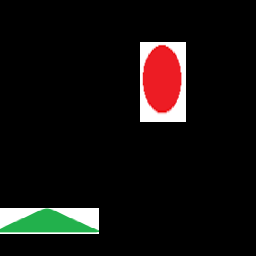

[[[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [1.         0.91623862 0.96481751 0.18693351 0.31530057 1.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[1.         0.57486617 0.59459708 0.39162452 0.1064244  0.
   0.         1.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]]


In [ ]:
# 랜덤하게 위치하도록 도형 그리고, 실제 정답 값을 생성하는 함수 정의
def make_img_label():
    img = np.zeros((hight_size + 400, width_size + 400, channel_size))
    label = np.zeros((cell_num, cell_num, label_num))      # 정답 클래스 레이블
    num_shape = np.random.randint(1, 4)            # 1~3까지 랜덤한 정수
    i = np.random.choice(range(cell_num), num_shape, replace=False)     # 0~2 중 'num_shape'개의 표본 추출
    j = np.random.choice(range(cell_num), num_shape, replace=False)

    img_0 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/github/DL-self-study/tensorflow/data/0.png')
    img_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/github/DL-self-study/tensorflow/data/1.png')
    img_2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/github/DL-self-study/tensorflow/data/2.png')

    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        shape_type = np.random.randint(0, class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 + 0.1
        h_rate = np.random.rand() * 0.3 + 0.1

        label[row, col] = [1, x_rate, y_rate, w_rate, h_rate, 0, 0, 0]
        label[row, col, 5 + shape_type] = 1
        x = int(x_rate * width_size/cell_num + col * width_size/cell_num)
        y = int(y_rate * hight_size/cell_num + row * hight_size/cell_num)
        w = int(w_rate * width_size/2) * 2
        h = int(h_rate * hight_size/2) * 2
        if (shape_type == 0):
            input_img = cv2.resize(img_0, (w, h))
        if (shape_type == 1):
            input_img = cv2.resize(img_1, (w, h))
        if (shape_type == 2):
            input_img = cv2.resize(img_2, (w, h))
        img[y - int(h/2) + 200 : y + int(h/2) + 200, x - int(w/2) + 200 : x + int(w/2) + 200] = input_img
    img = img[200:200+hight_size, 200:200+width_size]

    return img, label

img, label = make_img_label()
cv2_imshow(img)
print(label)

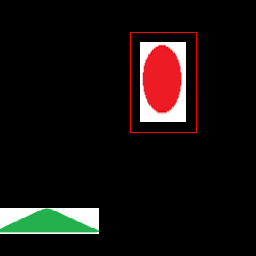

In [ ]:
# image와 정답(혹은 예측 값)을 넣으면 box를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th 이상일 때만 box 생성)
def show_box(img, label, th=0.3):
    b_img = np.zeros((hight_size + 400, width_size + 400, 3))
    b_img[200 : 200 + hight_size, 200 : 200 + width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if (label[i, j, 0] > th):
                x_rate = label[i, j, 1]
                y_rate = label[i, j, 2]
                w_rate = label[i, j, 3]
                h_rate = label[i, j, 4]
                shape_type = np.argmax(label[i, j, 5:])
                if (shape_type == 0):
                    line_color = [0, 0, 255]
                if (shape_type == 1):
                    line_color = [255, 0, 0]
                if (shape_type == 2):
                    line_color = [0, 255, 0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * hight_size/3 + i * hight_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * hight_size/2) * 2 + 20
                cv2.rectangle(b_img, (x-int(w/2) + 200, y-int(h/2) + 200), (x+int(w/2) + 200, y+int(h/2) + 200),
                                                                           line_color)
        
        b_img = b_img[200:200+hight_size, 200:200+width_size]
        return b_img

cv2_imshow(show_box(img, label))

객체 탐지 모델의 어느 정도 성능을 갖기 위해서는 복잡한 구조로 구현되어야 함. 전이 학습 방법을 적용하여 이미지 feature(특징)을 추출하는 데 좋은 성능을 갖는 모델을 기본으로 활용하는 것이 좋음.

In [ ]:
# VGG16 model을 base로 두고, 마지막 부분만 수정하는(=>Conv2D, Dense layer를 마지막 객체 탐지 분류기로 설정) model 생성(전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top=False, input_shape=img_size)
vgg_model.trainable = False
i = tf.keras.Input(shape=img_size)
out = tf.keras.layers.Lambda((lambda x: x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256, 3, padding='same')(out)
out = tf.keras.layers.Conv2D(128, 3, padding='same')(out)
out = tf.keras.layers.Conv2D(64, 3, padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024, activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8, activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3,3,8))(out)
yolo_model = tf.keras.Model(inputs=[i], outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# model 요약
yolo_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                              

In [ ]:
# learning 과정을 동영상으로 기록
fcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('hjk_yolo.avi', fcc, 1.0, (width_size, hight_size))
for e in range(epoch_num):
    img, label = make_img_label()
    img = np.reshape(img, (1, hight_size, width_size, 3))
    label = np.reshape(label, (1, 3, 3, 8))
    loss_p_list = []
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)
        # image를 구분한 셀을 탐험(image를 총 9개(3*3)의 셀로 나누고 셀마다 학습 진행.)
        for i in range(3):
            for j in range(3):
                # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
                if (label[0, i, j, 0] == 1):
                    loss_p_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
                    loss_cod_list.append(tf.square(label[0, i, j, 1] - pred[0, i, j, 1]))
                    loss_cod_list.append(tf.square(label[0, i, j, 2] - pred[0, i, j, 2]))
                    loss_cod_list.append(tf.square(label[0, i, j, 3] - pred[0, i, j, 3]))
                    loss_cod_list.append(tf.square(label[0, i, j, 4] - pred[0, i, j, 4]))
                    loss_c_list.append(tf.square(label[0, i, j, 5] - pred[0, i, j, 5]))
                    loss_c_list.append(tf.square(label[0, i, j, 6] - pred[0, i, j, 6]))
                    loss_c_list.append(tf.square(label[0, i, j, 7] - pred[0, i, j, 7]))
                # 해당 셀에 객체가 없을 경우, 없을 확률만 loss로 계산
                else:
                    loss_p_no_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
            
            loss_p = tf.reduce_mean(loss_p_list)
            loss_cod = tf.reduce_mean(loss_cod_list)
            loss_c = tf.reduce_mean(loss_c_list)
            loss_p_no = tf.reduce_mean(loss_p_no_list)

            # 각 loss를 비중을 곱해 더해 최종 loss 계산
            loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c     \
                      + loss_p_no_rate * loss_p_no

        # loss에 대한 Grad를 구하고, 각 파라미터 업데이트
        vars = yolo_model.trainable_variables
        grad = tape.gradient(loss, vars)
        opt.apply_gradients(zip(grad, vars))

        # 100번마다 동영상에 이미지 기록
        if (e % 100 == 0):
            img = np.reshape(img, (256, 256, 3))
            label = pred.numpy()
            label = np.reshape(label, (3, 3, 8))
            sample_img = np.uint8(show_box(img, label))
            out.write(sample_img)
        print(e, "완료", loss.numpy())

out.release()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15000 완료 0.020072589
15001 완료 0.03445601
15002 완료 0.04411638
15003 완료 0.006950234
15004 완료 0.034104947
15005 완료 0.029567866
15006 완료 0.03193843
15007 완료 0.06107638
15008 완료 0.15836264
15009 완료 0.006138645
15010 완료 0.01847601
15011 완료 0.020448191
15012 완료 0.036306016
15013 완료 0.03448826
15014 완료 0.014993329
15015 완료 0.10091103
15016 완료 0.05730073
15017 완료 0.06876125
15018 완료 0.012320199
15019 완료 0.037856217
15020 완료 0.034803923
15021 완료 0.027923163
15022 완료 0.07990571
15023 완료 0.040793296
15024 완료 0.028294094
15025 완료 0.016593466
15026 완료 0.033377536
15027 완료 0.020740291
15028 완료 0.048448976
15029 완료 0.009281209
15030 완료 0.022543972
15031 완료 0.03387757
15032 완료 0.03225007
15033 완료 0.04537594
15034 완료 0.048664298
15035 완료 0.034023527
15036 완료 0.044890158
15037 완료 0.02711952
15038 완료 0.053427774
15039 완료 0.26894692
15040 완료 0.06224775
15041 완료 0.025592988
15042 완료 0.034226194
15043 완료 0.09783337
15044 완료 0.017512696
15045 완료 0.029519629
15046 완료 0.07545

동영상을 실행해 학습 과정을 보면, 약 10,000번 학습이 이루어지고 난 뒤부터는 객체 탐지를 어느 정도 수준에서는 잘 해내는 것을 확인 가능.